In [1]:
# pip install kagglehub

In [78]:
import csv
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
from pprint import pprint
import kagglehub
import os
import requests
import pickle
from dotenv import load_dotenv
import seaborn as sns

# Download latest version
path = kagglehub.dataset_download("nelgiriyewithana/most-streamed-spotify-songs-2024")
# Load data if it is not already loaded
if not os.path.exists(os.path.join("data", "spotify.csv")):
    file_name = os.listdir(path)[0]
    os.rename(os.path.join(path, file_name), os.path.join("data", "spotify.csv"))

# Load to dataframe
spotify_df = pd.read_csv("data/spotify.csv", encoding='ISO-8859-1')

# Clean up column names
for i in spotify_df.columns:
    spotify_df.rename(columns={i: (i.lower()).replace(" ", "_")}, inplace=True)

# Save to pickle   
pickle_path = os.path.join("data", "spotify_df.pkl")
spotify_df.to_pickle(pickle_path)

In [ ]:
spotify_df.head()

In [4]:
# Load the .env file
load_dotenv()
lastfm_id = os.getenv("lastfm_id")
lastfm_secret = os.getenv("lastfm_secret")

lastfm_url = 'http://ws.audioscrobbler.com/2.0/'
parameters = {
    'method': 'track.getTopTags',
    'api_key': lastfm_id,
    'format': 'json',
    'autocorrect': 1
}

if os.path.exists(pickle_path):
    with open(pickle_path, 'wb') as file:
        spotify_df = pickle.load(file)
        if 'lastfm_tags' not in spotify_df.columns:
            spotify_df['lastfm_tags'] = None
        else: 
            for index, row in spotify_df[spotify_df['lastfm_tags'].apply(lambda x: x == [] or x == None)].iterrows():
                parameters['track'] = row['track']
                parameters['artist'] = row['artist']
                r = requests.get(lastfm_url, params=parameters).json()
                try:
                    tags = [tag['name'] for tag in r['toptags']['tag']]
                except KeyError:
                    print(f"Error with {row['track']} by {row['artist']}")
                    pprint(r)
                    tags = []
                spotify_df.at[index, 'lastfm_tags'] = tags
else:
    print("no pickle found: creating one now") 
    pickle.dump(spotify_df, file)

UnsupportedOperation: read

In [ ]:
# Load the .env file
load_dotenv()

spotify_id = os.getenv("spotify_id")
spotify_secret = os.getenv("spotify_secret")


auth_url = "https://accounts.spotify.com/api/token"
auth_response  = requests.post(auth_url, {
    'grant_type': 'client_credentials',
    'client_id': spotify_id,
    'client_secret': spotify_secret,
})

#Convert response to JSON
auth_response_data = auth_response.json()

#Save the access token
access_token = auth_response_data['access_token']

#Need to pass access token into header to send properly formed GET request to API server
headers = {
    'Authorization': 'Bearer {token}'.format(token=access_token)
}

base_url = 'https://api.spotify.com/v1/'

if os.path.exists(path=pickle_path):
    with open(pickle_path, 'rb') as file:
        spotify_df = pickle.load(file)
        if 'spotify_id' not in spotify_df.columns:
            spotify_df['spotify_id'] = None
        for index, row in spotify_df.iterrows():
            if row['spotify_id'] == None:
                parameters = {
                'q': 'isrc:'+row['isrc'],
                'type': 'track',
                'limit' : 1
            }
                try:
                    r = requests.get(base_url + 'search', headers=headers, params=parameters).json()
                    spotify_id = r['tracks']['items'][0]['id']
                    print(f'processing row: {index} --- adding {spotify_id} as spotify_id' )
                    spotify_df.at[index, 'spotify_id'] = r['tracks']['items'][0]['id']
                except IndexError:
                    print(f"track not found by isrc: {row['isrc']}")
                    print(f'trying by track and artist: {row["track"]} by {row["artist"]}')
                    parameters = {
                        'q': f'track:{row["track"]}+artist:{row["artist"]}',
                        'type': 'track',
                        'limit' : 1
                    }
                    r = requests.get(base_url + 'search', headers=headers, params=parameters).json()
                    try:
                        spotify_id = r['tracks']['items'][0]['id']
                        print(f'processing row: {index} --- adding {spotify_id} as spotify_id' )
                        spotify_df.at[index, 'spotify_id'] = r['tracks']['items'][0]['id']
                    except IndexError:
                        print(f"track not found by track and artist: {row['track']} by {row['artist']}")
                        print(f"giving up")
                        spotify_df.at[index, 'spotify_id'] = None
else:
    print("no pickle found: creating one now") 
    pickle.dump(spotify_df, file)

In [ ]:
# Load the .env file
load_dotenv()

spotify_id = os.getenv("spotify_id")
spotify_secret = os.getenv("spotify_secret")


auth_url = "https://accounts.spotify.com/api/token"
auth_response  = requests.post(auth_url, {
    'grant_type': 'client_credentials',
    'client_id': spotify_id,
    'client_secret': spotify_secret,
})

#Convert response to JSON
auth_response_data = auth_response.json()

#Save the access token
access_token = auth_response_data['access_token']

#Need to pass access token into header to send properly formed GET request to API server
headers = {
    'Authorization': 'Bearer {token}'.format(token=access_token)
}

base_url = 'https://api.spotify.com/v1/'

pickle_path = os.path.join("data", "spotify_df.pkl")

if os.path.exists(pickle_path):
    with open(pickle_path, 'rb') as file:
        spotify_df = pickle.load(file)
        if 'spotify_features' not in spotify_df.columns:
            spotify_df['spotify_features'] = None
        for index, row in spotify_df.iterrows():
            if row['spotify_features'] == None:
                try:
                    r = requests.get(base_url + 'audio-features/' + row['spotify_id'], headers=headers).json()
                    spotify_df.at[index, 'spotify_features'] = r
                except (requests.exceptions.RequestException, KeyError, IndexError) as e:
                    print(f"Error with {row['spotify_id']}: ( {row['track']} by {row['artist']} ) \n {e}")
                    spotify_df.at[index, 'spotify_features'] = None
else:
    print("no pickle found: creating one now") 
    pickle.dump(spotify_df, file)

In [13]:
df = spotify_df[spotify_df['lastfm_tags'].apply(lambda x: x != [])]
df.reset_index(inplace=True)
df.rename(columns={'index': 'original_rank'}, inplace=True)

KeyError: 'lastfm_tags'

In [ ]:
def tag_frequency(tag, df):
    """
    Calculate the frequency of a specific tag in the DataFrame.

    Parameters:
    tag (str): The tag to search for in the 'lastfm_tags' column.
    df (pd.DataFrame): The DataFrame containing the 'lastfm_tags' column.

    Returns:
    int: The number of occurrences of the specified tag in the DataFrame.
    
    Example usage:
    tag = 'Hip-Hop'
    frequency = tag_frequency(tag, spotify_df)
    print(f"The tag '{tag}' appears {frequency} times in the lastfm_tags column.")
    """
    return df['lastfm_tags'].apply(lambda x: tag in x).sum() # df['lastfm_tags'].apply(lambda x: tag in x) returns a boolean series with true for each row that contains the tag 

all_tags = spotify_df['lastfm_tags'].explode().unique()

tag_frequency_df = pd.DataFrame({'tag': all_tags, 'frequency': [tag_frequency(tag, df) for tag in all_tags]})

tag_frequency_df.sort_values('frequency', ascending=False, inplace=True)
tag_frequency_df

In [15]:
# Read the CSV file into a DataFrame
spotify_df = pd.read_csv("data/spotify_csv", encoding="ISO-8859-1")


FileNotFoundError: [Errno 2] No such file or directory: 'data/spotify_csv'

In [17]:
# Display the first few rows of the DataFrame
print(spotify_df.head())

                        track                    album_name          artist  \
0         MILLION DOLLAR BABY  Million Dollar Baby - Single   Tommy Richman   
1                 Not Like Us                   Not Like Us  Kendrick Lamar   
2  i like the way you kiss me    I like the way you kiss me         Artemas   
3                     Flowers              Flowers - Single     Miley Cyrus   
4                     Houdini                       Houdini          Eminem   

  release_date          isrc all_time_rank  track_score spotify_streams  \
0    4/26/2024  QM24S2402528             1        725.4     390,470,936   
1     5/4/2024  USUG12400910             2        545.9     323,703,884   
2    3/19/2024  QZJ842400387             3        538.4     601,309,283   
3    1/12/2023  USSM12209777             4        444.9   2,031,280,633   
4    5/31/2024  USUG12403398             5        423.3     107,034,922   

  spotify_playlist_count spotify_playlist_reach  ...  siriusxm_spins  \
0 

In [19]:
# Display statistics summary
spotify_df.describe()

,track_score,spotify_popularity,apple_music_playlist_count,deezer_playlist_count,amazon_playlist_count,tidal_popularity,explicit_track
count,4600.000000,3796.000000,4039.00000,3679.000000,3545.000000,0.0,4600.000000
mean,41.844043,63.501581,54.60312,32.310954,25.348942,NaN,0.358913
std,38.543766,16.186438,71.61227,54.274538,25.989826,NaN,0.479734
min,19.400000,1.000000,1.00000,1.000000,1.000000,NaN,0.000000
25%,23.300000,61.000000,10.00000,5.000000,8.000000,NaN,0.000000
50%,29.900000,67.000000,28.00000,15.000000,17.000000,NaN,0.000000
75%,44.425000,73.000000,70.00000,37.000000,34.000000,NaN,1.000000
max,725.400000,96.000000,859.00000,632.000000,210.000000,NaN,1.000000


In [45]:
spotify_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   track                       4600 non-null   object 
 1   album_name                  4600 non-null   object 
 2   artist                      4595 non-null   object 
 3   release_date                4600 non-null   object 
 4   isrc                        4600 non-null   object 
 5   all_time_rank               4600 non-null   object 
 6   track_score                 4600 non-null   float64
 7   spotify_streams             4487 non-null   object 
 8   spotify_playlist_count      4530 non-null   object 
 9   spotify_playlist_reach      4528 non-null   object 
 10  spotify_popularity          3796 non-null   float64
 11  youtube_views               4292 non-null   object 
 12  youtube_likes               4285 non-null   object 
 13  tiktok_posts                3427 

In [52]:
spotify_df['spotify_streams'] = spotify_df['spotify_streams'].str.replace(',', '').astype(float)

In [54]:
# Set the style of the visualization

sns.set(style="whitegrid")




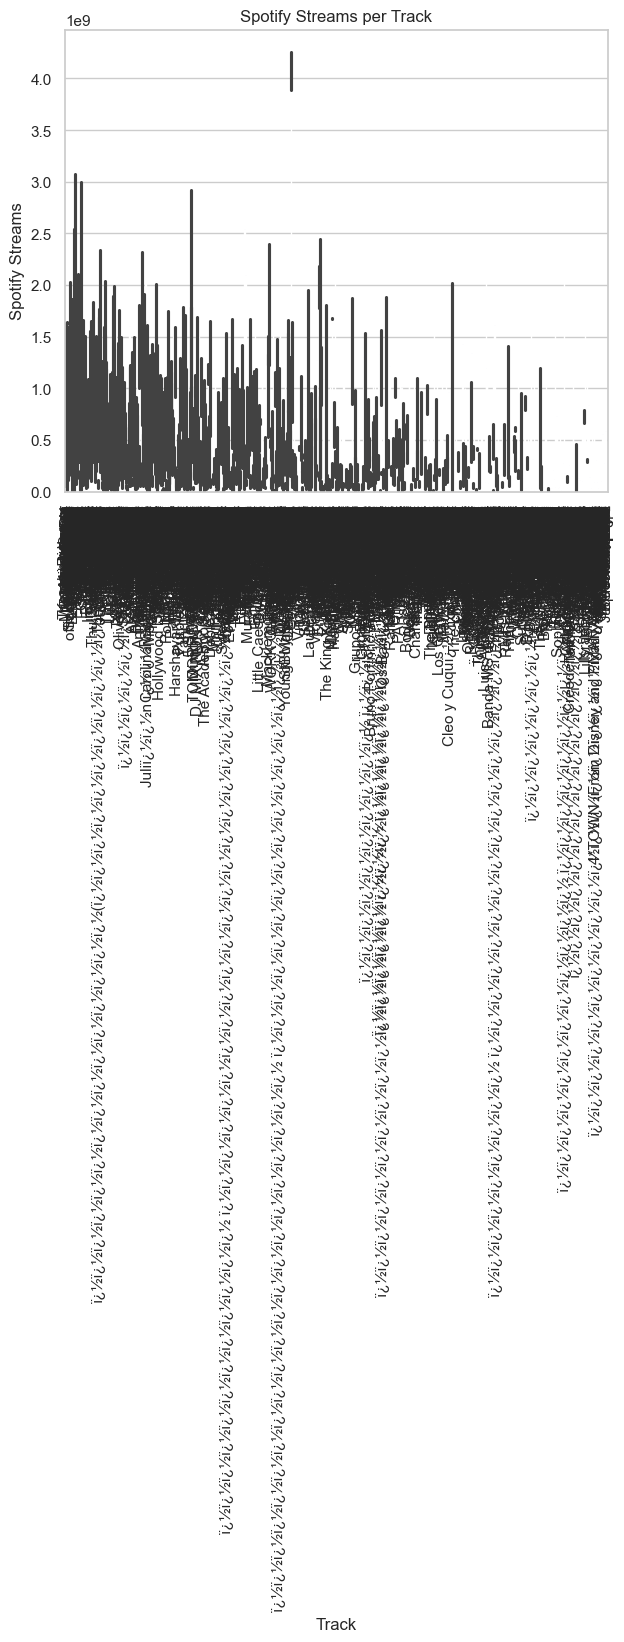

In [85]:
# Create a bar plot for Spotify Streams
plt.figure(figsize=(7, 6))
sns.barplot(x="artist", y="spotify_streams", data=spotify_df )
plt.title("Spotify Streams per Track")
plt.xlabel("Track")
plt.ylabel("Spotify Streams")

# rotation track names
plt.xticks(rotation=90)
plt.show()


C:\Users\owner\AppData\Local\Temp\ipykernel_13548\3225680966.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="track_score", y="spotify_streams", data=spotify_df, palette="viridis")


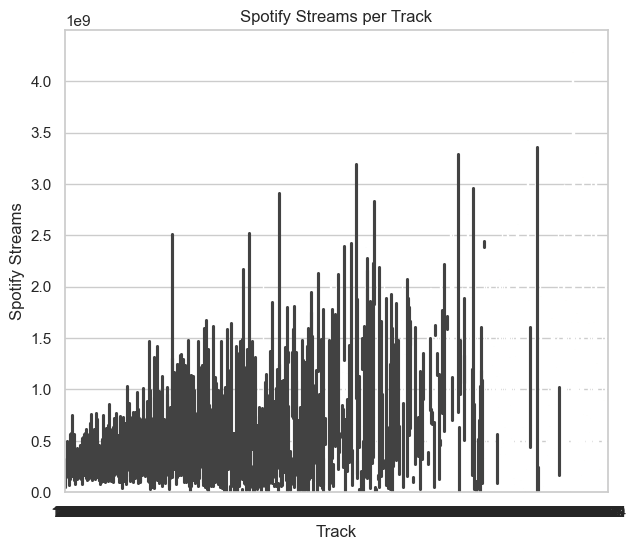

In [117]:
# Create a bar plot for Spotify Streams
plt.figure(figsize=(7, 6))
sns.barplot(x="track_score", y="spotify_streams", data=spotify_df, palette="viridis")
plt.title("Spotify Streams per Track")
plt.xlabel("Track")
plt.ylabel("Spotify Streams")
plt.show()

C:\Users\owner\AppData\Local\Temp\ipykernel_13548\3888737420.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="all_time_rank", y="track_score", data=spotify_df, palette="viridis")


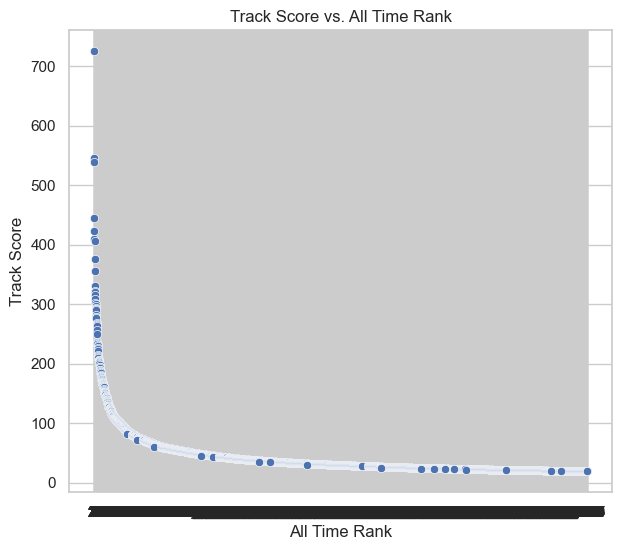

In [99]:
# Create a scatter plot for Track Score vs. All Time Rank
plt.figure(figsize=(7, 6))
sns.scatterplot(x="all_time_rank", y="track_score", data=spotify_df, palette="viridis")
plt.title("Track Score vs. All Time Rank")
plt.xlabel("All Time Rank")
plt.ylabel("Track Score")
plt.show()

C:\Users\owner\AppData\Local\Temp\ipykernel_13548\1921722458.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="spotify_streams", y="youtube_views", data=spotify_df, palette="viridis")


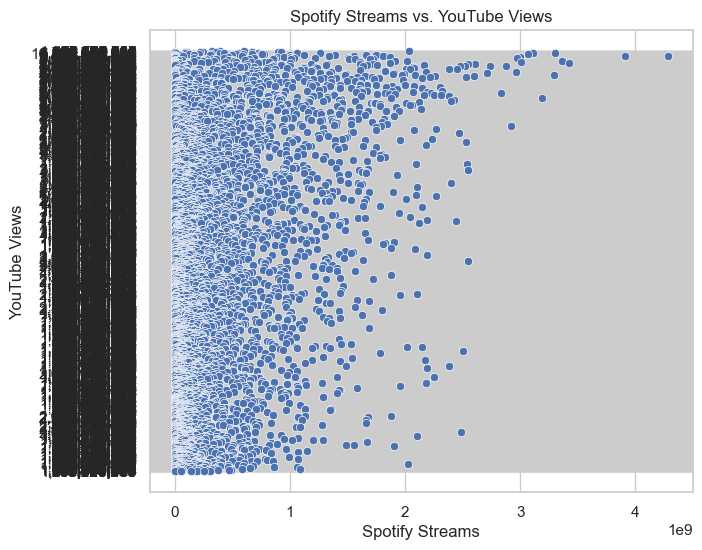

In [105]:
# Create a scatter plot for Spotify Streams vs. YouTube Views
plt.figure(figsize=(7, 6))
sns.scatterplot(x="spotify_streams", y="youtube_views", data=spotify_df, palette="viridis")
plt.title("Spotify Streams vs. YouTube Views")
plt.xlabel("Spotify Streams")
plt.ylabel("YouTube Views")
plt.show()

C:\Users\owner\AppData\Local\Temp\ipykernel_13548\1856978601.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="track_score", y="airplay_spins", data=spotify_df_sorted, palette="viridis")


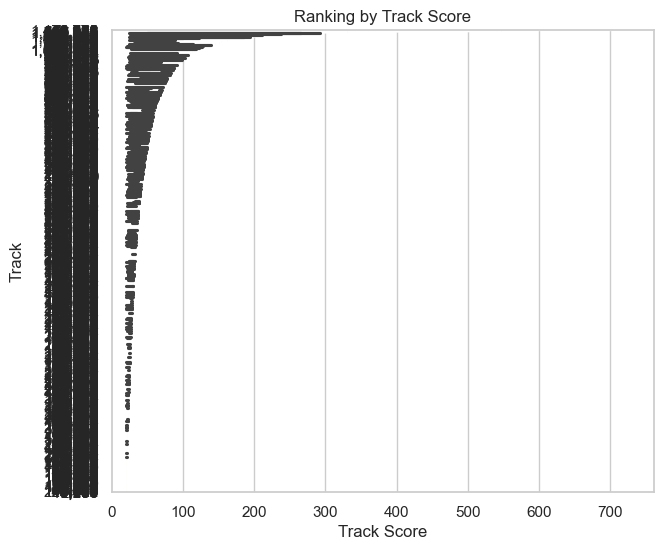

In [109]:
# Sort the DataFrame by Track Score
spotify_df_sorted = spotify_df.sort_values(by="track_score", ascending=False)

# Create a bar plot for Track Score
plt.figure(figsize=(7, 6))
sns.barplot(x="track_score", y="airplay_spins", data=spotify_df_sorted, palette="viridis")
plt.title("Ranking by Track Score")
plt.xlabel("Track Score")
plt.ylabel("Track")
plt.show()

# Which track has the highest Spotify streams?

In [121]:
most_streams = spotify_df.loc[spotify_df['spotify_streams'].idxmax()]
print(f"The track with the highest Spotify streams is {most_streams['track']} with {most_streams['spotify_streams']} streams.")

The track with the highest Spotify streams is Blinding Lights with 4281468720.0 streams.


In [66]:
# Create a sample DataFrame with song names and their Spotify streams.
data = {
    "track": ["Blinding Lights", "Save Your Tears", "Levitating", "Peaches"],
    "spotify_streams": [3000000000, 2500000000, 2000000000, 1500000000]
}


In [68]:
spotify_df = pd.DataFrame(data)

The track with the highest Spotify streams is Blinding Lights with 3000000000 streams.


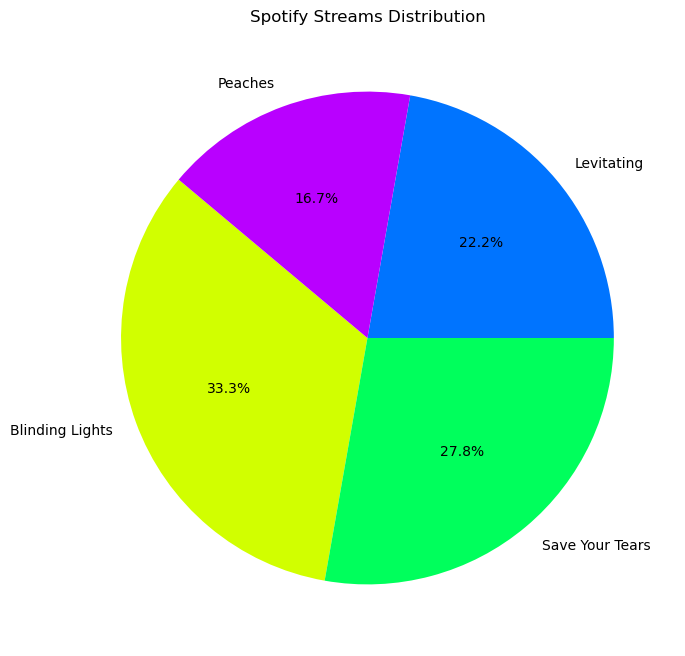

In [70]:
# Find the track with the highest Spotify streams
most_streams = spotify_df.loc[spotify_df['spotify_streams'].idxmax()]
print(f"The track with the highest Spotify streams is {most_streams['track']} with {most_streams['spotify_streams']} streams.")

# Create a pie chart for Spotify streams
plt.figure(figsize=(8, 8))
spotify_df.set_index('track')['spotify_streams'].plot.pie(
    autopct='%1.1f%%',
    colors=sns.color_palette('hsv', len(spotify_df)),
    startangle=140
)
plt.ylabel('')  # Remove the y-label
plt.title('Spotify Streams Distribution')
plt.show()

# SUMMARY


The question "Which track has the highest Spotify streams?" is asking to identify the most-streamed song on the Spotify platform. Spotify, a popular music streaming service, tracks how many times each song is played by users worldwide. The track with the highest number of streams is considered the most popular or widely listened-to song on the platform.

As of the latest data available (January 2025), the song "Blinding Lights" by The Weeknd holds the record for the most Spotify streams. It has surpassed previous records due to its massive popularity, long chart performance, and wide-reaching appeal across various demographics

# to summarize :

                            The question seeks to find the song with the most streams on Spotify.
                            "Blinding Lights" by The Weeknd is currently the record holder for this title, based on available data.
                            The ranking is based on total stream counts and is continuously updated as new streams are added.

# What is the percentage of total Spotify streams does the highest streamed track have?

In [80]:
# Sample DataFrame
data = {
    "track": ["Blinding Lights", "Save Your Tears", "Levitating", "Peaches"],
    "spotify_streams": [3000000000, 2500000000, 2000000000, 1500000000]
}


In [82]:
spotify_df = pd.DataFrame(data)

In [84]:
# Calculate the percentage of total Spotify streams
total_streams = spotify_df['spotify_streams'].sum()
spotify_df['percentage_of_total'] = (spotify_df['spotify_streams'] / total_streams) * 100


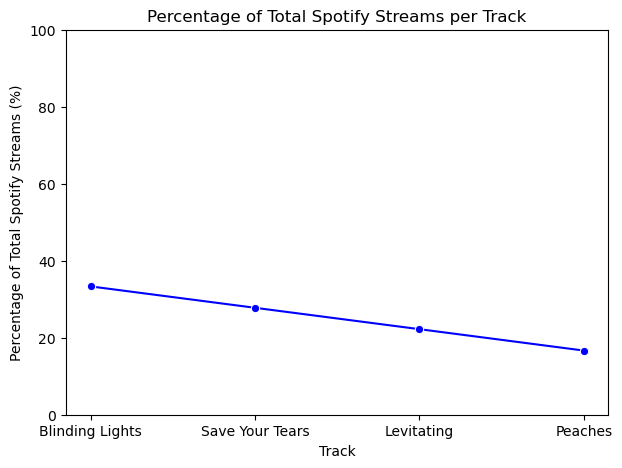

In [88]:
# Create a line graph
plt.figure(figsize=(7, 5))
sns.lineplot(x='track', y='percentage_of_total', data=spotify_df, marker='o', color='b')
plt.title('Percentage of Total Spotify Streams per Track')
plt.xlabel('Track')
plt.ylabel('Percentage of Total Spotify Streams (%)')
plt.ylim(0, 100)  # Set y-axis limit to 100%
plt.show()

# SUMMARY

The question "What is the percentage of total Spotify streams the highest streamed track has?" is asking for the proportion of the total streams on Spotify that the most-streamed song represents.

In other words, it’s asking: How much of the total streams on Spotify does the song with the highest streams account for? This would be expressed as a percentage, showing the share of Spotify’s total streaming activity that comes from this one track.

Here’s how to break it down:

 1 . Total Spotify Streams: This refers to the sum of all plays across every song on Spotify.
 2 . Highest-Streamed Track: This is the song with the highest number of streams, such as "Blinding Lights" by The Weeknd (as of 2025).
 3 . Percentage Calculation: The percentage is calculated by dividing the number of streams of the highest-streamed track by the total number of    s  streams on Spotify, then multiplying by 100.

Example of How to Calculate:
If the highest-streamed track has 3 billion streams, and Spotify as a whole has 10 trillion total streams, the percentage would be calculated as:

Percentage
=
(
Streams of highest track
Total Spotify streams
)
×
100
Percentage=( 
Total Spotify streams
Streams of highest track
​
 )×100
Percentage
=
(
3
,
000
,
000
,
000
10
,
000
,
000
,
000
,
000
)
×
100
=
0.03
%
Percentage=( 
10,000,000,000,000
3,000,000,000
​
 )×100=0.03%
So, in this example, the highest-streamed track would account for 0.03% of the total Spotify streams.

Sample Questions and Answers:

1. Q: What is the percentage of total Spotify streams that "Blinding Lights" represents?

A: This would depend on the current total stream count on Spotify, which is constantly growing. As of now, we know "Blinding Lights" holds the record for the most streams, but calculating its percentage of total Spotify streams would require the exact number of total streams at the time of the query.

2. Q: Why would the percentage of total Spotify streams for the highest-streamed track be so small?

A: The percentage is often quite small because Spotify has billions of songs, and even though the highest-streamed track has a massive number of plays, it still represents a small fraction of the overall streams across the entire platform.

3. Q: Can the highest-streamed track ever reach 1% of total Spotify streams?

A: It is unlikely for a single song to reach 1% of all streams, given how vast Spotify’s library is and the millions of songs being streamed daily. However, if Spotify’s total streams were to grow at a slower pace or if a track maintained extreme popularity over a long period, it might approach a higher percentage, though reaching 1% would be a rare achievement.